In [1]:
!pip install openai langchain ipywidgets pandas ipywidgets
!pip install faiss-cpu --no-cache
!pip install tiktoken
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.ticker as ticker
import math
from ipywidgets import widgets
#pd.set_option('display.max_colwidth', None)

import os
import openai
from IPython.display import display, Markdown
import json

from langchain.chat_models import ChatOpenAI

from langchain.prompts import ChatPromptTemplate
from langchain import PromptTemplate, LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores.faiss import FAISS
import pickle

from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser


In [3]:
def load_credentials(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    lines = content.split('\n')
    username = lines[0].split(': ')[1]
    api_key = lines[1].split(': ')[1]

    username = username.strip()
    api_key = api_key.strip()

    return username, api_key

In [4]:
username, api_key = load_credentials('Data/Key.txt')
openai.api_key = api_key
os.environ['OPENAI_API_KEY'] = api_key

# Topic Classification and Storage for Newspaper Articles

This project focuses on developing a recommender system for newspaper articles. The objective is to align user queries with the most pertinent articles based on topic similarities. The overall process is depicted in the figure below. Since a simple embedding match between a user query and an article might not capture the user's desired topics, we've employed the Large Language Model, GPT-3.5-turbo, to assign a list of topics to each article in the news database. These topics are then embedded and stored in a vector store.

We treat user queries similarly, using the Large Language Model to extract the topics of interest to the user. Then, we identify the most similar topics using cosine similarity search in the vector data store. Following this, we re-rank the suggested articles based on two mechanisms. One introduces noise to the similarity search to maintain dissimilarity and novelty in the search results. The other incorporates user feedback from previous queries. The influence of these two mechanisms is adaptively adjusted with the number of queries - as the influence of noise decreases, the impact of user ratings increases. Ultimately, this results in a content-based recommender system that operates in a session-based manner.

1. **Topic Assignment:** The ChatGPT language model processes each article, assigning topics from a predefined list based on the text content.

2. **Vector Representation:** After assigning topics to each article, we represent these topics as vectors in a high-dimensional space using the FAISS (Facebook AI Similarity Search) library from Facebook AI. The aim here is to leverage these vector representations to find the closest match to a user's query.

3. **User Query Interpretation:** A large language model is used to interpret the user's query and extract the desired topics.

4. **Similarity Search and Article Recommendation:** We perform a similarity search within the precomputed vector space to recommend the most relevant articles to the user.

5. **Re-ranking based on Noise Introduction and User Feedback:** The suggested articles are re-ranked by introducing noise to maintain dissimilarity and novelty in the search results, and by incorporating user feedback from previous queries. The influence of these mechanisms is adaptively adjusted with the number of queries.


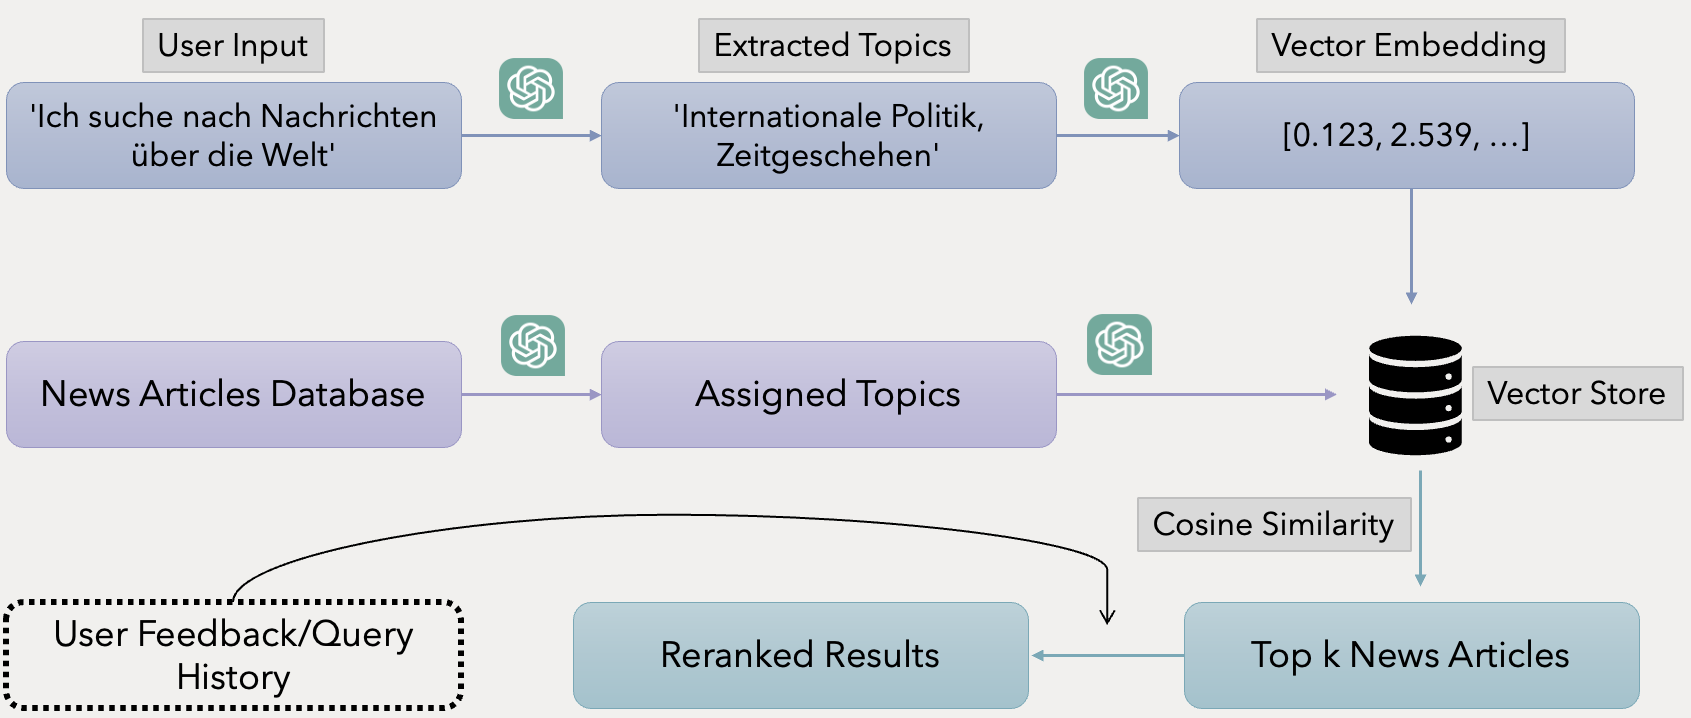

In [5]:
#Load Data
file = "Data/cleaned_df.csv"
df = pd.read_csv(file)

# Vectore Database laden
with open("vectorstore.pkl", "rb") as f:
    vector_store = pickle.load(f)

In [6]:
# processes the list of all topics in the documents of the vectore store
# extracts and counts the occurrence of each topic, storing the results in the all_topics dictionary.
#transforms this dictionary to associate each topic with a weight, its total count, and a user count placeholder.
all_topics = {}
for entry in list(vector_store.docstore._dict.values()):
    doc = dict(entry)['page_content']
    topics = doc.split(',')
    for t in topics:
        if t.strip() in list(all_topics.keys()):
            all_topics[t.strip()]+=1
        else:
            all_topics[t.strip()] =1

# This Dictionary is used to store the weight, count how often it appears in the database and how often the user has rated
# the topic. The user count starts at 1 due to the rating modification procedure.

all_topics = {key: {'weight':1., 'count':value, 'user_count':1} for key, value in all_topics.items()}
all_topics_keys = list(all_topics.keys())
len(list(all_topics_keys))

296

In [7]:
#load previously stored qeries, these are used for teh sytem template and the human template
with open('prompt_templates/recommendations/templates.json', 'r') as json_file:
    templates=json.load(json_file)

In [8]:
with open ('prompt_templates/recommendations/examples_prediction.json', 'r') as handle:
    zero_shot = json.load(handle)

In [9]:
# First lets try the recommender with a chain that doesnt use any memory but zero shot examples

system_message_prompt = SystemMessagePromptTemplate.from_template(templates['system5'])
human_message_prompt = HumanMessagePromptTemplate.from_template(templates['human2'])

example_human = HumanMessagePromptTemplate.from_template(zero_shot['human_example2'])
example_ai = AIMessagePromptTemplate.from_template(zero_shot['ai_example2'])

chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, example_human, example_ai, human_message_prompt])

chat = ChatOpenAI(temperature=0)
chain = LLMChain(llm=chat, prompt=chat_prompt)

In [192]:
chain.run(topics= all_topics_keys, userinput='Ich suche nach Nachrichten über Tiere')

'Tiere'

#### Analysis of the Generated Topics

After establishing the topic extraction chain, we utilized the 100 general queries generated to examine the behaviour of the Large Language Model (LLM) and assess the distribution of suggested topics and whether the chain generates new topics. In alignment with the topic assignment process, we observed a long-tailed distribution of topics. Furthermore, the majority of assignments in these queries contained two topics. However, we noticed that the system creates new topics, which could potentially be reduced by implementing a stricter system prompt.


In [10]:
with open('prompt_templates/evals/general_prompts.json','r') as handle:
    general_eval_set = json.load(handle)

In [11]:
resulting_topics =[]
for i in list(general_eval_set.values()):
    result = chain.run(topics= all_topics_keys, userinput=i[0]['prompt'])
    resulting_topics.append(result)

In [12]:
# Count the frequency of each unique topic
topic_counts = {}
for topic in resulting_topics:
    stripped_topic = topic.split(',')
    for i in stripped_topic:
        st = i.strip()
        if st in topic_counts:
            topic_counts[st] += 1
        else:
            topic_counts[st] = 1

# Calculate the distribution of topic lengths
topic_lengths = [len(topic.split(',')) for topic in resulting_topics]
length_counts = {}
for length in topic_lengths:
    if length in length_counts:
        length_counts[length] += 1
    else:
        length_counts[length] = 1


unique_topics = list(topic_counts.keys())
print('Unique topics:')
print(len(unique_topics))



Unique topics:
135


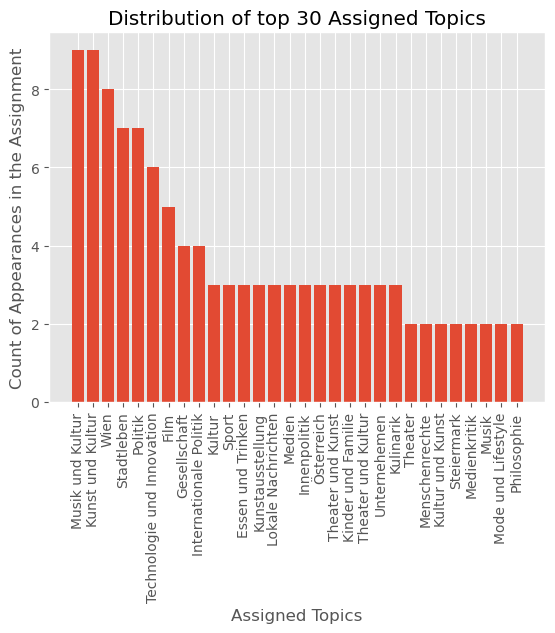

In [13]:
topic_counts = dict(sorted(topic_counts.items(), key=lambda x: x[1], reverse=True))

plt.title('Distribution of top 30 Assigned Topics')
plt.bar(list(topic_counts.keys())[:30], list(topic_counts.values())[:30])
plt.xlabel('Assigned Topics')
plt.ylabel('Count of Appearances in the Assignment')
plt.xticks(rotation=90)
plt.savefig('Figures/Prediction/dist_top_30_topics.pdf', format='pdf')
plt.show()

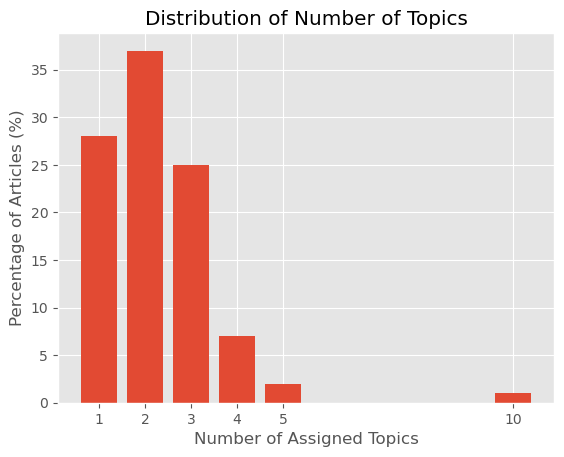

In [14]:
plt.bar(length_counts.keys(), length_counts.values())
plt.xlabel('Number of Assigned Topics')
plt.ylabel('Percentage of Articles (%)')
plt.title('Distribution of Number of Topics')
plt.xticks(list(length_counts.keys()))


plt.savefig('Figures/Prediction/dist_num_topics.pdf', format='pdf')
plt.show()

In [15]:
len(set(unique_topics)-set(all_topics_keys))

48

# Prediction Mechanism

As described previously and demonstrated in the preceding code snippets, our approach uses the Large Language Model (LLM) to extract topics of interest to a user. We then carry out a cosine similarity search in the Vector Store. The resultant list of top 'k' news articles and their scores undergo modification and re-ranking through the following procedure:

1. **Randomness:** Random noise, drawn from a normal distribution with an adaptive standard deviation setting, is added to the similarity score to maintain diversity in the recommendations.

2. **User Feedback:** User feedback, gathered through ratings, is incorporated as weights for each topic. As not all weights hold the same informational value, we calculate the weighted average weight first, with the weights being the number of times a user has given feedback on an item addressing the topic. Other considerations for re-ranking can include the frequency of the topic's appearance in the database. We use a temperature parameter to adjust the influence of the weights adaptively.

The adaptive schedules are illustrated in the following plots. We observe that the influence of randomness diminishes over time or number of queries, whereas the influence of ratings increases over time via the temperature parameter. Further enhancements could include introducing a decay rate that simulates short-term memory, wherein ratings for topics not rated for a long time gravitate towards the default value.

Furthermore, we detail how user ratings affect the weights. We give users the option to rate an article as good, bad, or ok. The treatment of good or bad ratings is fairly straightforward, but an 'ok' rating requires definition—we can have it exert no influence, or lean towards good or bad. The 'severity parameter' dictates the impact of a good or bad rating. We also confine the weight value to a specific range. This approach ensures diversity and continuous exploration of news articles, even when one topic might have received low ratings. By preventing a weight from reaching 0, we can still recommend articles of interest to the user that might involve other interesting topics. Similarly, we cap the maximum weight to prevent a single rating from dominating all others.


In [16]:
def format_similarity_search_output(output):
    """
    Formats the output of the similarity search to include the id, topics and similarity score of each result.

    Args:
        output (list): List of tuples where each tuple consists of a dictionary (with metadata and page_content) and a similarity score.

    Returns:
        list: Returns a list of dictionaries. Each dictionary includes 'id' (article id), 'topics' (topics of the article), and 'score' (similarity score).
    """
    result =[]
    for i in output:
        inter_dict={}
        score = i[1]
        inter_dict_2=dict(i[0])
        inter_dict['id'] = inter_dict_2['metadata']['id']
        inter_dict['topics'] = inter_dict_2['page_content']
        inter_dict['score'] =score

        result.append(inter_dict)
    return(result)

def modify_score(score_dict, weight_dict, temperature=1, randomness=1e-6, default=0.5, calculation_method='default'):
    """
    Modifies the original similarity score by incorporating user interaction counts, topic weights, and a random factor.

    Args:
        score_dict (dict): Dictionary containing 'topics' and original 'score'.
        weight_dict (dict): Dictionary containing weights, user interaction counts, and appearance counts for each topic.
        temperature (float, optional): Factor that controls the influence of the original score on the final score. Defaults to 1.
        randomness (float, optional): Standard deviation of the normal distribution used to add randomness to the final score. Defaults to 1e-6.
        calculation_method (str, optional): Method for calculating the weighted average. Valid values are 'default' and 'logarithm'. Defaults to 'default'.
        default(float, optional): default value for the weight of topic. Only necessary once we encounter a topic that is not present in the dictionary yet.

    Returns:
        dict: Returns the original score dictionary with an additional key 'mod_score' that contains the modified score.
    """
    stripped_list = [item.strip() for item in score_dict['topics'].split(',')]

    u_counts = []
    weights = []
    appearance_count = []

    for i in stripped_list:
        try:
            user_count = weight_dict[i]['user_count']
        except KeyError:
            # Entry not present in dictionary, add it with default values
            weight_dict[i] = {'user_count': 1, 'weight': default, 'count': 1}
            user_count = 1
        
        if calculation_method == 'default':
            u_counts.append(user_count)
        elif calculation_method == 'logarithm':
            u_counts.append(np.log(user_count))
        else:
            raise ValueError("Invalid calculation method. Valid values are 'default' and 'logarithm'.")

        weights.append(weight_dict[i]['weight'])
        appearance_count.append(weight_dict[i]['count'])

    weighted_average = sum(w * s for w, s in zip(weights, u_counts)) / sum(weights)

    random_number = np.random.normal(0, randomness)

    weighted_average += random_number

    score = score_dict['score'] + (temperature * weighted_average)

    score_dict['mod_score'] = score

    return score_dict


In [17]:
def modify_all_scores(score_list, weight_dict, temperature=1, randomness=1e-6, default = 0.5, calculation_method='default'):
    """
    Modifies the original similarity scores of all articles in the list by incorporating user interaction counts, topic weights, and a random factor.

    Args:
        score_list (list): List of dictionaries, where each dictionary contains 'topics' and original 'score'.
        weight_dict (dict): Dictionary containing weights, user interaction counts, and appearance counts for each topic.
        temperature (float, optional): Factor that controls the influence of the original score on the final score. Defaults to 1.
        randomness (float, optional): Standard deviation of the normal distribution used to add randomness to the final score. Defaults to 1e-6.
        calculation_method (str, optional): Method for calculating the weighted average. Valid values are 'default' and 'logarithm'.

    Returns:
        list: Returns a list of dictionaries with original and modified scores for each article.
    """
    result_list = list()
    for i in range(len(score_list)):
        result_list.append(modify_score(score_list[i], weight_dict, temperature, randomness, default, calculation_method))

    return result_list

In [18]:
def modify_rating_weights(topics, weight_dict, rating, severity, ok=0, smallest =1e-3, biggest=1):
    """
    Adjusts the weight of topics in the weight dictionary based on the user's rating and severity.

    Args:
        topics (str): A string of comma-separated topics associated with an article.
        weight_dict (dict): A dictionary containing weights and user interaction counts for each topic.
        rating (str): The user's rating of the article - 'good', 'bad', or any other string representing an "ok" rating.
        severity (float): A parameter representing the extent to which the rating should influence the topic's weight.
        ok (float, optional): A parameter representing the influence of an "ok" rating on the topic's weight. Defaults to 0.
        smallest (float, optional): The smallest possible weight a topic can have. Defaults to 1e-3.
        biggest (float, optional): The largest possible weight a topic can have. Defaults to 1.

    Returns:
        None. The function modifies the weight_dict in-place.
    """
    stripped_list = [item.strip() for item in topics.split(',')]

    for i in stripped_list:
        weight_dict[i]['user_count']+=1
        if rating =='good':
            weight_dict[i]['weight']+=severity
            if weight_dict[i]['weight']>biggest:
                weight_dict[i]['weight']=biggest

        elif rating =='bad':
            weight_dict[i]['weight']-=severity
            if weight_dict[i]['weight']<smallest:
                weight_dict[i]['weight']=smallest

        else:
            weight_dict[i]['weight']-=severity*ok
            if weight_dict[i]['weight']<smallest:
                weight_dict[i]['weight']=smallest
            
            if weight_dict[i]['weight']>biggest:
                weight_dict[i]['weight']=biggest

In [19]:
def reset_weights(weight_dict, default=0.5):
    """
    Resets the weights and user counts of all topics in the weight dictionary to 1.
    """
    for i in list(weight_dict.keys()):
        weight_dict[i]['weight']=default
        weight_dict[i]['user_count']=1

In [20]:
def perform_prediction(userinput, llm=chain, vector_store=vector_store, all_topic_dict=all_topics, k1=3, k2=3, df=df, temperature =1, randomness =1e-6, default=0.5, calculation_method='default'):
    """
    Uses the given language model to predict relevant articles for a user input query and applies a relevance score.

    Args:
        userinput (str): The user's query.
        llm (object, optional): The large language model used for assigning topics to the query. Defaults to 'chain'.
        vector_store (object, optional): The vector space storing the topics. Defaults to 'vector_store'.
        all_topic_dict (dict, optional): The dictionary of all topics. Defaults to 'all_topics'.
        k1 (int, optional): The number of most similar results to return from the similarity search. Defaults to 3.
        k2 (int, optional): The number of highest scoring results to return after score modification. Defaults to 3.
        df (DataFrame, optional): The DataFrame containing article information. Defaults to 'df'.
        temperature (float, optional): Factor controlling the influence of the original score on the final score. Defaults to 1.
        randomness (float, optional): Standard deviation of the normal distribution used to add randomness to the final score. Defaults to 1e-6.
        default (float, optional): default value for weights, hwich becomes necessary once we encounter a new topic.
        calculation_method (str, optional): Method for calculating the weighted average. Valid values are 'default' and 'logarithm'.

    Returns:
        list: A list of dictionaries, where each dictionary contains information about one of the k2 most relevant articles.
    """

    result = llm.run(userinput=userinput, topics = list(all_topic_dict.keys()))
    output = vector_store.similarity_search_with_relevance_scores(result, k=k1)
    score_dict = format_similarity_search_output(output)

    new_list = modify_all_scores(score_dict, all_topics, temperature=temperature, randomness=randomness, default=default, calculation_method='default')
    new_list = sorted(new_list, key=lambda x: x['mod_score'], reverse=True)

    selected_results = new_list[0:k2]

    for item in selected_results:
        id_value = item['id']
        matching_row = df[df['article_id'] == id_value]
        if not matching_row.empty:
            item['title'] = matching_row['title'].iloc[0]
            subtitle = matching_row['subtitle'].iloc[0]
            #item['subtitle'] = matching_row['subtitle'].iloc[0]
            if str(subtitle) == 'nan':
                item['subtitle'] = 'Leider nicht verfügbar :('
            else:
                item['subtitle'] = matching_row['subtitle'].iloc[0]

    return selected_results


In [21]:
def temp_schedule(max_t, num_queries, rate=1):
    """
    Generates a temperature schedule for score modification based on the number of queries.

    Args:
        max_t (float): Maximum temperature.
        num_queries (int): Number of queries made by the user.

    Returns:
        float: Returns the temperature value calculated based on the given schedule.
    """
    return max_t *(1-1/(1+ rate * num_queries))

def random_schedule(max_random, numb_queries):
    """
    Generates a randomness schedule for score modification based on the number of queries.

    Args:
        max_ranodm (float): Maximum randomness.
        numb_queries (int): Number of queries made by the user.

    Returns:
        float: Returns the randomness value calculated based on the given schedule.
    """
    return (max_random /math.log(numb_queries+1))

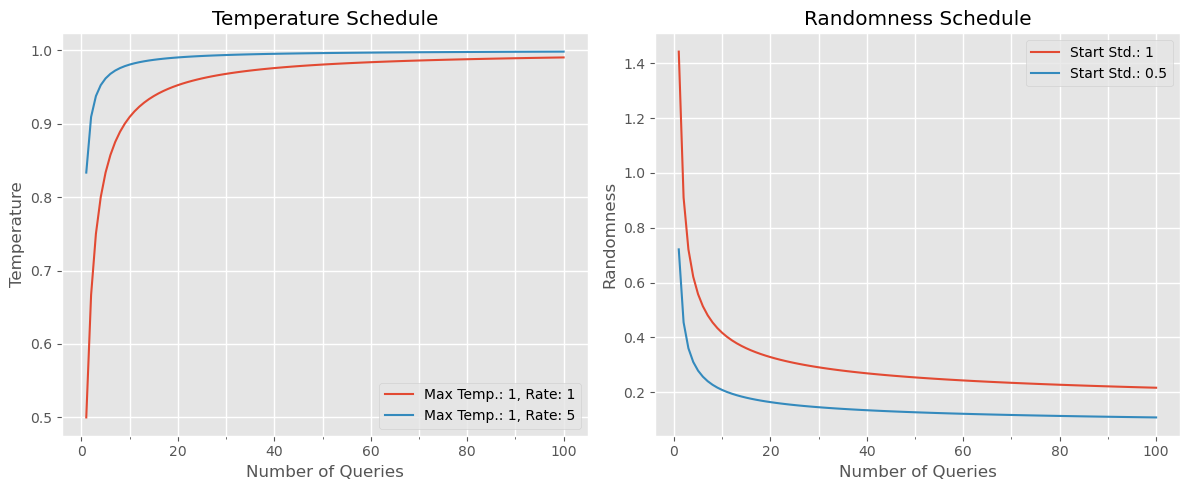

In [22]:
max_temperature = 1.0
max_randomness = 1.0
num_queries = np.arange(1, 101)  # Number of queries ranging from 1 to 100

temperature_values = [temp_schedule(max_temperature, nq) for nq in num_queries]
randomness_values = [random_schedule(max_randomness, nq) for nq in num_queries]

temperature_values_2 = [temp_schedule(1, nq, rate =5) for nq in num_queries]
randomness_values_2 = [random_schedule(0.5, nq) for nq in num_queries]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(num_queries, temperature_values, label='Max Temp.: 1, Rate: 1')
ax1.plot(num_queries, temperature_values_2, label='Max Temp.: 1, Rate: 5')
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Temperature')
ax1.set_title('Temperature Schedule')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax1.yaxis.grid(True, linewidth='1')
ax1.xaxis.grid(which='both', linewidth='1')
ax1.legend()



ax2.plot(num_queries, randomness_values, label='Start Std.: 1')
ax2.plot(num_queries, randomness_values_2, label='Start Std.: 0.5')
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Randomness')
ax2.set_title('Randomness Schedule')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax2.yaxis.grid(True, linewidth='1')
ax2.xaxis.grid(which='both', linewidth='1')
ax2.legend()


plt.tight_layout()
plt.savefig('Figures/Prediction/schedule.pdf', format='pdf')
plt.show()

## User Interface
After assembling all the necessary components for prediction, we developed a user interface. As previously stated, we are treating the recommender system in a session-based manner. This means we reset the weights each time the user interface is built or reloaded, ensuring no information is carried over. There are several critical hyperparameters to set, which are mentioned at the beginning of the code snippet.

The user inputs a query and is able to review all the suggestions. Each suggestion displays the title, subtitle, and covered topics of an article, providing the user with context for the recommendation. Users also have the option to rate the suggestions, which, as mentioned earlier, alters the weight of the specific topic. As the number of queries increases, the schedules for randomness and temperature parameters are adjusted accordingly.


In [23]:
# Hyperparameters
#default: The weight that each topic starts out with
default = 0.5

# Resets the weights of all topics to their initial state
reset_weights(all_topics, default)

# k1: The number of initial search results to fetch from the recommender system. This is 
# the initial pool of results that will be filtered and presented to the user.
k1 = 20

# k2: The number of final search results to present to the user. This is the final number 
# of recommendations the user will see from the initial pool of results.
k2 = 5

# t: The maximum value for the temperature schedule. The temperature schedule controls the 
# degree of random perturbation added to the weighted average when calculating the final score 
# for each search result.
t = 1

# r: The startung value for the randomness schedule. The randomness schedule controls the
# randomness applied during the score modification process to ensure diversity in the search results.
r = 0.1

#rt: The modifying paramater of the temperature schedule, values larger than 1 will increase the influecne of the weights
# faster vlaues below 1 slower
rt = 1

# s: Severity of the weight adjustments based on user ratings. The larger this value, the more 
# influence the user ratings have on the weight of the topics in the recommender system.
s = 0.05

# ok: The severity of weight adjustment when the user rates a search result as 'ok'. This can be 
# set to a value to control how much the weight adjustment should be in this scenario.
ok = 0

#method: The method used to adapt the score value based on the weight so far allowed values are default and 'default' and 'logarithm'
method = 'default'

#smallest: Smalles allowed value that the weight can take
smallest = 1e-3

#biggest: Biggest allowed value that the weight of a topic can take
biggest = 1



# Create input widgets
search_input = widgets.Textarea(
    placeholder='Enter your search query...',
    rows=4,
    layout=widgets.Layout(width='80%')
)
search_button = widgets.Button(description='Search')
search_box = widgets.HBox([search_input, search_button], layout=widgets.Layout(justify_content='center'))

# Create output widgets
id_output = widgets.Output()
title_output = widgets.Output()
subtitle_output = widgets.Output()
paragraphs_output = widgets.Output()
based_output = widgets.Output()

# Create buttons
button_prev = widgets.Button(description='Prev')
button_next = widgets.Button(description='Next')
button_bad = widgets.Button(description='Bad')
button_ok = widgets.Button(description='Ok')
button_good = widgets.Button(description='Good')

# Create button rows
navigation_buttons_row = widgets.HBox([button_prev, button_next], layout=widgets.Layout(justify_content='space-between'))
rating_buttons_row = widgets.HBox([button_bad, button_ok, button_good], layout=widgets.Layout(justify_content='center'))

# Create middle container
middle_container = widgets.VBox([id_output, title_output, subtitle_output, based_output], layout=widgets.Layout(min_height='250px', align_items='center'))

# Create vertical container
vertical_container = widgets.VBox([search_box, middle_container, navigation_buttons_row, rating_buttons_row],
                                  layout=widgets.Layout(width='100%', justify_content='center'))

# Create main container with max width
main_container = widgets.Box([vertical_container], layout=widgets.Layout(max_width='800px', justify_content='center', align_items='center'))


# Define variables
search_results = []
current_index = 0
num_queries = 0
# Define button click handlers
def search_button_click(btn):
    global search_results, current_index, num_queries
    # Process search query and get search results
    search_query = search_input.value
    num_queries +=1
    t_ad = temp_schedule(t, num_queries, rate =rt)
    r_ad = random_schedule(r,num_queries)
    search_results = perform_prediction(search_query, all_topic_dict=all_topics, k1=k1, k2=k2, df=df, temperature=t_ad, randomness = r_ad, default = default, calculation_method = method)  # Your search logic here
    current_index = 0  # Reset current index
    display_search_result()

def button_bad_click(btn):
    global current_index
    result = search_results[current_index]
    modify_rating_weights(result['topics'], weight_dict=all_topics, rating='bad', severity=s, ok=ok, smallest = smallest, biggest = biggest)
    # Handle "Bad" button click
    current_index += 1
    if current_index >=len(search_results):
        current_index =0
    display_search_result()

def button_ok_click(btn):
    global current_index
    result = search_results[current_index]
    modify_rating_weights(result['topics'], weight_dict=all_topics, rating='ok', severity=s, ok=ok, smallest =smallest , biggest=biggest)
    # Handle "Ok" button click
    current_index += 1
    if current_index >=len(search_results):
        current_index -=1 
    display_search_result()

def button_good_click(btn):
    global current_index
    result = search_results[current_index]
    modify_rating_weights(result['topics'], weight_dict=all_topics, rating='good', severity=s, ok=ok, smallest =1e-3, biggest=1)
    # Handle "Good" button click
    
    current_index += 1
    if current_index >=len(search_results):
        current_index -=1
    display_search_result()

def button_prev_click(btn):
    global current_index
    # Handle "Prev" button click
    if current_index > 0:
        current_index -= 1
    display_search_result()

def button_next_click(btn):
    global current_index
    # Handle "Next" button click
    if current_index < len(search_results) - 1:
        current_index += 1
    display_search_result()

# Attach button click handlers
search_button.on_click(search_button_click)
button_bad.on_click(button_bad_click)
button_ok.on_click(button_ok_click)
button_good.on_click(button_good_click)
button_prev.on_click(button_prev_click)
button_next.on_click(button_next_click)

# Define function to display search result at current index
def display_search_result():
    global search_results, current_index
    if search_results:
        result = search_results[current_index]
        with id_output:
            id_output.clear_output()
            print("Artikel Id: ", result['id'])
        with title_output:
            title_output.clear_output()
            print("Titel:", result['title'])
        with subtitle_output:
            subtitle_output.clear_output()
            print("Subtitle: ", result['subtitle'])
        with based_output:
            based_output.clear_output()
            print("Based on:", result['topics'])

        #with paragraphs_output:
            #paragraphs_output.clear_output()
            #for paragraph in result['paragraphs']:
                #print("Paragraph:", paragraph)
    else:
        with title_output:
            title_output.clear_output()
            print("No search results found.")

# Display the UI components
display(main_container)

Box(children=(VBox(children=(HBox(children=(Textarea(value='', layout=Layout(width='80%'), placeholder='Enter …

# Evaluation Methodology for the Recommender System

The evaluation of our recommender system relies on a large language model (LLM), as suggested by both LangChain's documentation and OpenAI's evals repository. In this setup, the evaluation itself is driven by the LLM. The general workflow was already described in the evlaution notebook. Summarizing the general idea:

We generated 100 prompts from 100 randomly selected news articles in a previous stage of this notebook. FOr each news article we have two seperate prompts:

1. **General Prompts**: These prompts are derived from a broad understanding of the article.
2. **Specific Prompts**: These prompts are tightly linked to the article's specific details.

These prompts are used to generate recommendations through our pipeline. To evaluate the relevance of these recommendations, we rely on the LLM. There are two evaluation settings:

1. **Relaxed Matching**: In this setting, the LLM is less strict in judging the match between user query topics and article topics.
2. **Strict Matching**: In this setting, the LLM adheres to a stricter matching criterion.

This methodology enables us to calculate key metrics such as recall, precision, mean average precision, and also examine if the original article from which the prompt was derived appears in the top 'k' recommendations. The process also offers insights into the influence of randomness and the potential impact of the 'temperature' parameter used in generating the prompts.

However, it's important to note that this evaluation methodology, while thorough, can be extremely costly. Moreover, its effectiveness may be hindered if the system prompts of the LLM are not engineered efficiently. Thus, while it provides a comprehensive picture of the situation, improvements can always be made to enhance the evaluation's precision and cost-effectiveness.


In [24]:
with open('prompt_templates/evals/general_prompts.json','r') as handle:
    general_eval_set = json.load(handle)

with open('prompt_templates/evals/specific_prompts.json','r') as handle:
    spe_eval_set = json.load(handle)

with open('prompt_templates/evals/eval_templates.json','r') as handle:
    eval_template = json.load(handle)

In [25]:
# General Evaluation Chain
relevance_schema_gen = ResponseSchema(name="relevance",
                            description=eval_template['schema'])

response_schemas_gen = [relevance_schema_gen]
output_parser_gen = StructuredOutputParser.from_response_schemas(response_schemas_gen)
format_instructions_gen = output_parser_gen.get_format_instructions()

system_message_prompt_eval_gen = SystemMessagePromptTemplate.from_template(eval_template['system'])
human_message_prompt_eval_gen = HumanMessagePromptTemplate.from_template(eval_template['human'])

chat_eval_gen = ChatOpenAI(temperature=0)
chat_prompt_eval_gen = ChatPromptTemplate.from_messages([system_message_prompt_eval_gen, human_message_prompt_eval_gen])
chain_eval_gen = LLMChain(llm=chat_eval_gen, prompt=chat_prompt_eval_gen)


# Relaxed Evaluation Chain
relevance_schema_rel = ResponseSchema(name="relevance",
                            description=eval_template['schema_relaxed_2'])

response_schemas_rel = [relevance_schema_rel]
output_parser_rel = StructuredOutputParser.from_response_schemas(response_schemas_rel)
format_instructions_rel = output_parser_rel.get_format_instructions()

system_message_prompt_eval_rel = SystemMessagePromptTemplate.from_template(eval_template['system_relaxed_2'])
human_message_prompt_eval_rel = HumanMessagePromptTemplate.from_template(eval_template['human'])

chat_eval_rel = ChatOpenAI(temperature=0)
chat_prompt_eval_rel = ChatPromptTemplate.from_messages([system_message_prompt_eval_rel, human_message_prompt_eval_rel])
chain_eval_rel = LLMChain(llm=chat_eval_rel, prompt=chat_prompt_eval_rel)

In [26]:
def eval_prompt(prompt, id, df=df, evaluation = 'strict'):
        """
        This function evaluates a given prompt based on its relevance to a specified article.

        Parameters:
        prompt (str): The prompt to be evaluated.
        id (str): The article_id of the article to be matched with the prompt.
        df (DataFrame): The DataFrame containing the articles. Default is `df`.
        instructions (function): A function to format the instructions for evaluation. Default is `format_instructions`.
        chain_eval (ChainEval): An instance of ChainEval class for running the evaluation. Default is `chain_eval`.

        Returns:
        dict: A dictionary containing the evaluation result and the id of the article.

        The function first identifies the row in the DataFrame that matches the provided `id`. It extracts the relevant features 
        of the article, such as the title, subtitle, main text, general topic, and more. 

        It then runs the `chain_eval` with these features and the provided prompt. The result is parsed and returned as a dictionary, 
        which includes the `id` of the article.

        """
        matching_row = df[df['article_id'] == id]
        title = matching_row['title'].values[0]
        subtitle = matching_row['subtitle'].values[0]
        text = matching_row['paragraphs'].values[0]
        rubrik = matching_row['rubrik'].values[0]
        general = matching_row['general_topic'].values[0]
        ressort = matching_row['ressort'].values[0]
        dach = matching_row['dachzeile'].values[0]
        
        if evaluation == 'strict':
            instructions = format_instructions_gen
            chain_eval = chain_eval_gen
            output_parser = output_parser_gen
        
        elif evaluation == 'relaxed':
            instructions = format_instructions_rel
            chain_eval = chain_eval_rel
            output_parser = output_parser_rel
        else :
            raise ValueError("Invalid evaluation method. Valid values are 'strict' and 'relaxed'.")

        result = chain_eval.run(format_instructions = instructions, title = title, subtitle = subtitle,text=text, rubrik = rubrik, resort=ressort, general=general, dachzeile=dach, prompt = prompt)
        
        result_dict = output_parser.parse(result)
        result_dict['id'] = id
        return result_dict

In [27]:
def eval_search(prompts, j=1, all_topic_dict=all_topics, k1=20, k2=5, df=df, temperature=1, randomness = 0, default = 0.5, calculation_method = 'default', eval_method = 'strict'):
    """
    This function evaluates the search performance of a list of prompts by running predictions, evaluating prompts and 
    storing evaluation results.

    Parameters:
    prompts (dict): A dictionary containing prompts along with corresponding answers.
    j (int): The number of prompts to be evaluated. Default is 1.
    all_topic_dict (dict): The dictionary of all topics. Default is `all_topics`.
    k1 (int): The number of initial articles to consider for recommendation. Default is 20.
    k2 (int): The number of final articles to recommend after second filtering. Default is 5.
    df (DataFrame): The DataFrame containing the articles. Default is `df`.
    temperature (float): The temperature parameter for controlling the randomness of predictions.
    randomness (float): The randomness factor to apply during prediction.

    Returns:
    list: A list of dictionaries where each dictionary contains the prompt, answer and the relevance score of the 
    recommended articles.

    The function iterates over the number of prompts specified. For each prompt, it performs predictions and evaluates 
    each prediction by comparing it with the actual article using the `eval_prompt` function. The evaluation results are 
    then stored in a dictionary along with the prompt and the answer. All these dictionaries are appended to a list 
    which is then returned.
    """
    ovr_results = []
    
    for i in range(j):
        
        search_query = prompts[str(i)][0]['prompt']
        search_results = perform_prediction(search_query, all_topic_dict=all_topics, k1=k1, k2=k2, df=df, temperature=temperature, randomness = randomness, default = default, calculation_method = method)
        eval_res_dict = {'prompt':search_query, 'answer':prompts[str(i)][0]['answer']}

        eval_result = []
        for z in range(len(search_results)):
            eval_dict = eval_prompt(search_query, search_results[z]['id'], df=df, evaluation=eval_method)
            eval_dict['score'] = search_results[z]['score']
            eval_dict['mod_score'] = search_results[z]['mod_score']
            
            eval_result.append(eval_dict)

        eval_res_dict['relevance']=eval_result

        ovr_results.append(eval_res_dict)

    return(ovr_results)


In [236]:
%%time

res = eval_search(general_eval_set,j=1,k1=1, k2=1, randomness=0, temperature=1, eval_method='relaxed')
res

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: You exceeded your current quota, please check your plan and billing details..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: You exceeded your current quota, please check your plan and billing details..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: You exceeded your current quota, please check your plan and billing details..


KeyboardInterrupt: 

#### Evaluation Functions

In [28]:
def calculate_precision(entry, k):
    """
    Calculates the precision for a single entry.
    """
    relevant_recommendations = sum(1 for recommendation in entry['relevance'][:k] if recommendation['relevance'])
    total_recommendations = len(entry['relevance'][:k])
    if total_recommendations == 0:
        return 0
    return relevant_recommendations / float(total_recommendations)


def calculate_recall(entry, k):
    """
    Calculates the recall for a single entry.
    """
    relevant_recommendations = sum(1 for recommendation in entry['relevance'][:k] if recommendation['relevance'])
    total_relevant = sum(1 for recommendation in entry['relevance'] if recommendation['relevance'])
    if total_relevant == 0:
        return 0
    return relevant_recommendations / float(total_relevant)


def calculate_all_metrics(data):
    """
    Calculate average precision and recall at all k for all entries in data.
    Note that is not the definition of the average percision See next code
    """
    max_k = max(len(entry['relevance']) for entry in data)
    metrics = []

    for k in range(1, max_k + 1):
        total_precision = 0
        total_recall = 0
        for entry in data:
            total_precision += calculate_precision(entry, k)
            total_recall += calculate_recall(entry, k)

        average_precision = total_precision / len(data)
        average_recall = total_recall / len(data)
        metrics.append((k, average_precision, average_recall))

    return metrics


In [29]:
calculate_all_metrics(res)

NameError: name 'res' is not defined

In [30]:
def calculate_precision_at_recall_increase(entry, k):
    """
    Calculates the precision only at the ranks when a new relevant item is recalled.
    """
    precision_values = []
    for i in range(k):
        if entry['relevance'][i]['relevance']:
            relevant_recommendations = sum(1 for recommendation in entry['relevance'][:i+1] if recommendation['relevance'])
            total_recommendations = i + 1
            precision_values.append(relevant_recommendations / total_recommendations)
    return precision_values


def calculate_average_precision(entry):
    """
    Calculates the average precision for a single entry.
    """
    precision_values = calculate_precision_at_recall_increase(entry, len(entry['relevance']))
    if precision_values:
        return sum(precision_values) / len(precision_values)
    return 0


def calculate_mean_average_precision(data):
    """
    Calculate Mean Average Precision (MAP) over all entries in data.
    """
    average_precisions = [calculate_average_precision(entry) for entry in data]
    mean_average_precision = sum(average_precisions) / len(average_precisions)
    return mean_average_precision


In [31]:
calculate_mean_average_precision(res)

NameError: name 'res' is not defined

In [32]:
def calculate_percentage_answer_in_all_k(data):
    """
    Calculates the percentage of entries where the answer ID is in the top k recommendations for all k.
    """
    max_k = max(len(entry['relevance']) for entry in data)
    results = []

    for k in range(1, max_k + 1):
        count = 0
        for entry in data:
            recommendation_ids = [recommendation['id'] for recommendation in entry['relevance'][:k]]
            if entry['answer'] in recommendation_ids:
                count += 1
        results.append((k, count / len(data) * 100))

    return results

In [33]:
calculate_percentage_answer_in_all_k(res)

NameError: name 'res' is not defined

# System Evaluation and Analysis

The system evaluation is based on several key metrics, defined in the previous code snippets. We utilize mean top-k recall, mean top-k precision, average precision, and the percentage of prompts in which the exact news article is suggested in the recommendation list. This approach offers a comprehensive high-level overview of the system's performance. However, it's important to bear in mind that the evaluation pipeline itself might be imperfect as it relies on the large language model (LLM) to judge relevance.

The system's performance is first analyzed in a scenario devoid of noise or user feedback influence. This is carried out on both the general and specific prompt sets, under both strict and relaxed evaluation settings. However, due to the computational cost of each evaluation, we restrict subsequent analysis to the general prompt set and the relaxed evaluation chain. This selection gives us the most generic insight into system performance.

In the next phase, we experiment with adding noise, introducing it at five separate query stages as per the noise schedule. The starting standard deviation is 0.25, the number of queries steps are 1,2,5,15,100. In each setting we first extract the top 25 similar articles and then add noise to select the top 5 to recommend to the user. This addition is inherently stochastic, and due to budget limitations, we can't replicate this evaluation multiple times.

Another facet we explore is the influence of the weights. This is done by artificially modifying the weights of the top 20 topics that emerge when using the general prompt set. After the weight modification, we explore different temperature settings.

Throughout this analysis, we must remember the cost implications of this evaluation process, which restrict us considerably. Despite not having any ground truth values or user data, this approach allows us to evaluate the system with relative ease and scalability, albeit costly. The resulting lists of dictionaries are stored in the 'results' folder.


In [34]:
#Baseline performance without any noise or weight influence

#first lets try without any noise or user feedback taking 5 recommendations per query
res = eval_search(general_eval_set,j=100,k1=5, k2=5, randomness=0, temperature=1, eval_method='relaxed')


UsageError: Line magic function `%%time` not found.


In [159]:
with open ('Results/gen_prompts_relaxed_chain_rand_0_t_1_k_5.json', 'w') as handle:
    json.dump(res,handle)

In [160]:
print(calculate_all_metrics(res))
print(calculate_mean_average_precision(res))
print(calculate_percentage_answer_in_all_k(res))


[(1, 0.44, 0.1277460317460317), (2, 0.365, 0.18971428571428564), (3, 0.3533333333333333, 0.2579603174603175), (4, 0.345, 0.33770634920634907), (5, 0.3379999999999999, 0.40669047619047616), (6, 0.32666666666666655, 0.44751984126984146), (7, 0.317142857142857, 0.48472619047619064), (8, 0.31625, 0.5466984126984124), (9, 0.3133333333333333, 0.5996825396825396), (10, 0.3090000000000001, 0.66)]
0.4456683830939783
[(1, 2.0), (2, 3.0), (3, 3.0), (4, 6.0), (5, 6.0), (6, 6.0), (7, 6.0), (8, 6.0), (9, 7.000000000000001), (10, 8.0)]


In [185]:
#Influence of Noise
num_rounds = [1,2,5,15,100]
for i in num_rounds:
    r_ad = random_schedule(0.25, i)
    r_ad_formatted = "{:.3f}".format(r_ad)
    filename = f'Results/gen_prompts_relaxed_chain_rand_{r_ad_formatted}_t_1_k1_25_k2_5.json'
    res = eval_search(general_eval_set,j=100,k1=25, k2=5, randomness=r_ad, temperature=1, eval_method='relaxed')
    
    with open (filename, 'w') as handle:
        json.dump(res,handle)


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 04 Jul 2023 07:03:17 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-reva

In [66]:
top50_topics = list(topic_counts.keys())[:50]

In [36]:
def modify_weights_of_topics(weight_dict, topics, weight, ucount):
    for i in topics:
        try:
            weight_dict[i]['weight'] = weight
            weight_dict[i]['user_count'] = ucount
        except KeyError:
            weight_dict[i] = {'weight': weight, 'count': 1, 'user_count': ucount}
            
        

In [37]:
modify_weights_of_topics(all_topics, top20_topics, 1, 10)
reset_weights(all_topics)

In [63]:

num_rounds = [1,2,5,15,100]
num_counts = [1]

for j in num_counts:
    reset_weights(all_topics, default=0.5)
    modify_weights_of_topics(all_topics, top20_topics, 1, j)
    for i in num_rounds:
        t_ad = temp_schedule(2, i, rate =0.5)
        t_ad_formatted = "{:.3f}".format(t_ad)
        filename = f'Results/gen_prompts_relaxed_chain_rand_0_t_{t_ad_formatted}_k1_25_k2_5_ucount_{j}.json'
        print(filename)
        res = eval_search(general_eval_set,all_topic_dict=all_topics,j=100,k1=25, k2=5, randomness=0, temperature=t_ad, eval_method='relaxed')
    
        with open (filename, 'w') as handle:
            json.dump(res,handle)


Results/gen_prompts_relaxed_chain_rand_0_t_0.667_k1_25_k2_5_ucount_1_top50.json


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 04 Jul 2023 13:50:57 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7e17cf7c4d1bc29b-VIE', 'alt-svc': 'h3=":443"; ma=86400'}.
Retrying langchain.chat_mod

Results/gen_prompts_relaxed_chain_rand_0_t_1.000_k1_25_k2_5_ucount_1_top50.json


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 04 Jul 2023 14:07:24 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7e17e79b5c4538b8-VIE', 'alt-svc': 'h3=":443"; ma=86400'}.
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_mod

Results/gen_prompts_relaxed_chain_rand_0_t_1.429_k1_25_k2_5_ucount_1_top50.json


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 04 Jul 2023 14:36:25 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7e181214ec9f301d-VIE', 'alt-svc': 'h3=":443"; ma=86400'}.
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_mod

Results/gen_prompts_relaxed_chain_rand_0_t_1.765_k1_25_k2_5_ucount_1_top50.json
Results/gen_prompts_relaxed_chain_rand_0_t_1.961_k1_25_k2_5_ucount_1_top50.json


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 04 Jul 2023 15:08:04 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7e1840776dfe300d-VIE', 'alt-svc': 'h3=":443"; ma=86400'}.


In [68]:
num_rounds_rd = [1,100]
num_rounds_temp = [1,100]
num_counts = [1]

for j in num_counts:
    reset_weights(all_topics, default=0.5)
    modify_weights_of_topics(all_topics, top50_topics, 1, j)
    for i in num_rounds_rd:
        for k in num_rounds_temp:
            t_ad = temp_schedule(2, k, rate =0.5)
            r_ad = random_schedule(0.25, i)
            t_ad_formatted = "{:.3f}".format(t_ad)
            r_ad_formatted = "{:.3f}".format(r_ad)
            filename = f'Results/gen_prompts_relaxed_chain_rand_{r_ad_formatted}_t_{t_ad_formatted}_k1_25_k2_5_ucount_{j}.json'
            print(filename)
            res = eval_search(general_eval_set,all_topic_dict=all_topics,j=100,k1=25, k2=5, randomness=r_ad, temperature=t_ad, eval_method='relaxed')

            with open (filename, 'w') as handle:
                json.dump(res,handle)


Results/gen_prompts_relaxed_chain_rand_0.361_t_0.667_k1_25_k2_5_ucount_1.json


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..


Results/gen_prompts_relaxed_chain_rand_0.361_t_1.961_k1_25_k2_5_ucount_1.json


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 04 Jul 2023 16:20:58 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7e18ab442c19c27f-VIE', 'alt-svc': 'h3=":443"; ma=86400'}.


Results/gen_prompts_relaxed_chain_rand_0.054_t_0.667_k1_25_k2_5_ucount_1.json


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 04 Jul 2023 16:31:37 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7e18badf08e5c242-VIE', 'alt-svc': 'h3=":443"; ma=86400'}.
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad

Results/gen_prompts_relaxed_chain_rand_0.054_t_1.961_k1_25_k2_5_ucount_1.json


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 04 Jul 2023 16:52:50 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7e18d9f18e2b2f61-VIE', 'alt-svc': 'h3=":443"; ma=86400'}.


In [67]:
random_schedule(0.25, 100)

0.054169766333882916

In [39]:
def plot_metrics(list_data, dict_settings, filename=None, title='Any Title'):
    """
    Generate and display bar plots for precision, recall, and mean average precision (mAP) metrics.

    Args:
        list_data (list): List of data sets.
        dict_settings (dict): Dictionary mapping settings to labels.
        filename (str, optional): Name of the output file to save the plots. Defaults to None.
        title (str, optional): Title for the plots. Defaults to 'Any Title'.

    Returns:
        None
    """
    all_metrics = []
    mAP = []
    
    for data in list_data:
        all_metrics.append(calculate_all_metrics(data))
        mAP.append(calculate_mean_average_precision(data))
        
    precision = []
    recall = []
    k_values = []
    
    for metrics in all_metrics:
        k_values, precision_values, recall_values = zip(*metrics)
        precision.append(precision_values)
        recall.append(recall_values)

    N = len(k_values)
    ind = np.arange(N)
    width = 0.8 / len(precision)  # Adjusted width of the bars

    fig, ax = plt.subplots(figsize=(12, 7))
    for i in range(len(precision)):
        ax.bar(ind + i * width, precision[i], width, label=dict_settings[i+1], edgecolor='black')

    ax.set_xlabel('Rank k', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title('Top-k Precision for Different Settings ' + title)
    ax.set_xticks(ind + (len(precision) - 1) * width / 2)  # Adjusted position of x-ticks
    ax.set_xticklabels(k_values)
    ax.legend(fontsize=12)

    if filename is not None:
        plt.savefig(filename + '_precision.pdf', format='pdf')

    # Adjust y-axis limit for precision plot
    max_precision = max(max(precision_values) for precision_values in precision)
    ax.set_ylim([0, round(max_precision + 0.2, 1)])

    plt.show()

    fig, ax = plt.subplots(figsize=(12, 7))
    for i in range(len(recall)):
        ax.bar(ind + i * width, recall[i], width, label=dict_settings[i+1], edgecolor='black')

    ax.set_xlabel('Rank k', fontsize=14)
    ax.set_ylabel('Recall', fontsize=14)
    ax.set_title('Top-k Recall for Different Settings ' + title)
    ax.set_xticks(ind + (len(recall) - 1) * width / 2)  # Adjusted position of x-ticks
    ax.set_xticklabels(k_values)
    ax.legend(fontsize=12)
    
    if filename is not None:
        plt.savefig(filename + '_recall.pdf', format='pdf')

    # Adjust y-axis limit for recall plot
    max_recall = max(max(recall_values) for recall_values in recall)
    ax.set_ylim([0, round(max_recall + 0.2, 1)])
    
    plt.show()

    N = len(mAP)
    r = range(N)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    plt.figure(figsize=(12, 7))
    for i in r:
        plt.bar(i, mAP[i], color=colors[i % len(colors)], label=dict_settings[i+1], edgecolor='black')

    plt.ylim([0, 1])
    plt.title('Mean Average Precision for Settings ' + title)
    plt.xlabel('Setting')
    plt.ylabel('Mean Average Precision')
    plt.xticks(range(N), [r+1 for r in range(N)])  # Adjusted x-tick labels
    plt.legend()

    if filename is not None:
        plt.savefig(filename + '_mAP.pdf', format='pdf')

    plt.show()


In [50]:
with open('Results/gen_prompts_strict_chain_rand_0_t_1_k_5.json', 'r') as handle:
    res1 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1_k_5.json', 'r') as handle:
    res2 = json.load(handle)

with open('Results/spe_prompts_strict_chain_rand_0_t_1_k_5.json', 'r') as handle:
    res3 = json.load(handle)

with open('Results/spe_prompts_relaxed_chain_rand_0_t_1_k_5.json', 'r') as handle:
    res4 = json.load(handle)

dict_settings = {1:'Gen. Prompts, Strict Eval.', 2:'Gen. Prompts, Relaxed Eval.', 3:'Spec. Prompts, Strict Eval.', 4:'Spec. Prompts, Relaxed Eval.'}

list_data = [res1, res2, res3, res4]

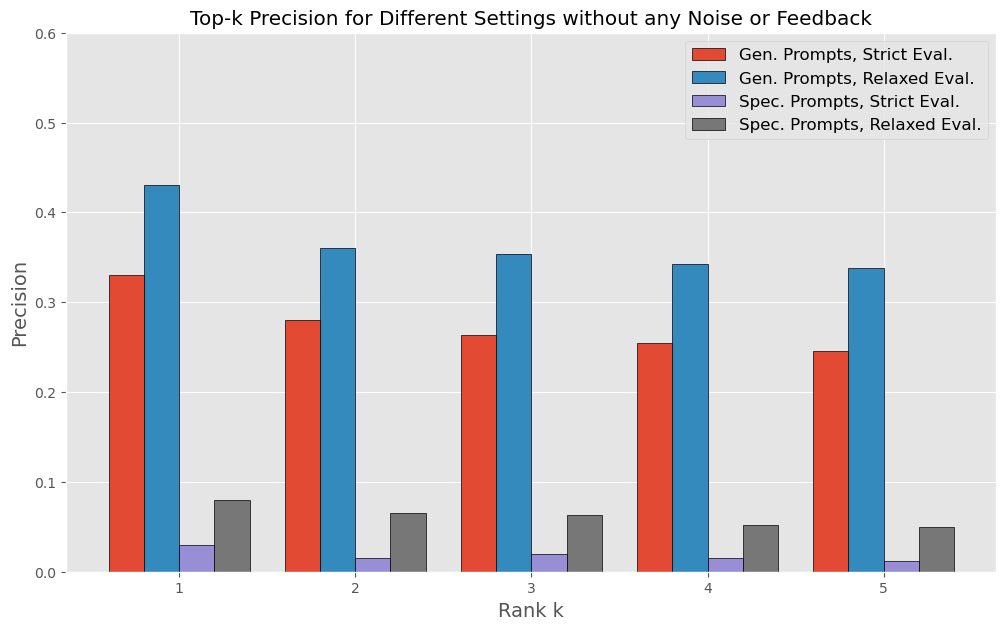

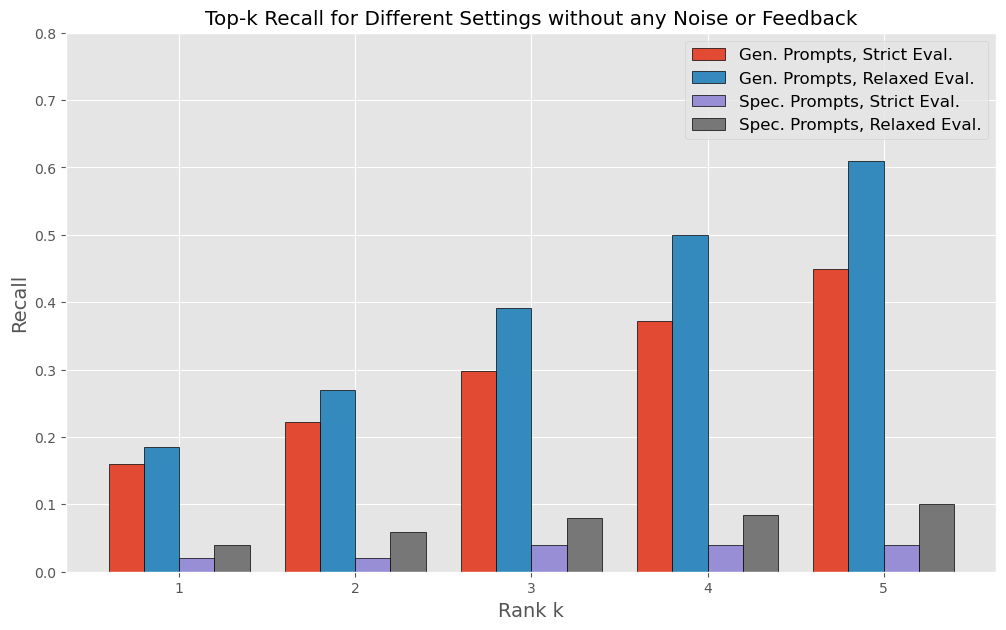

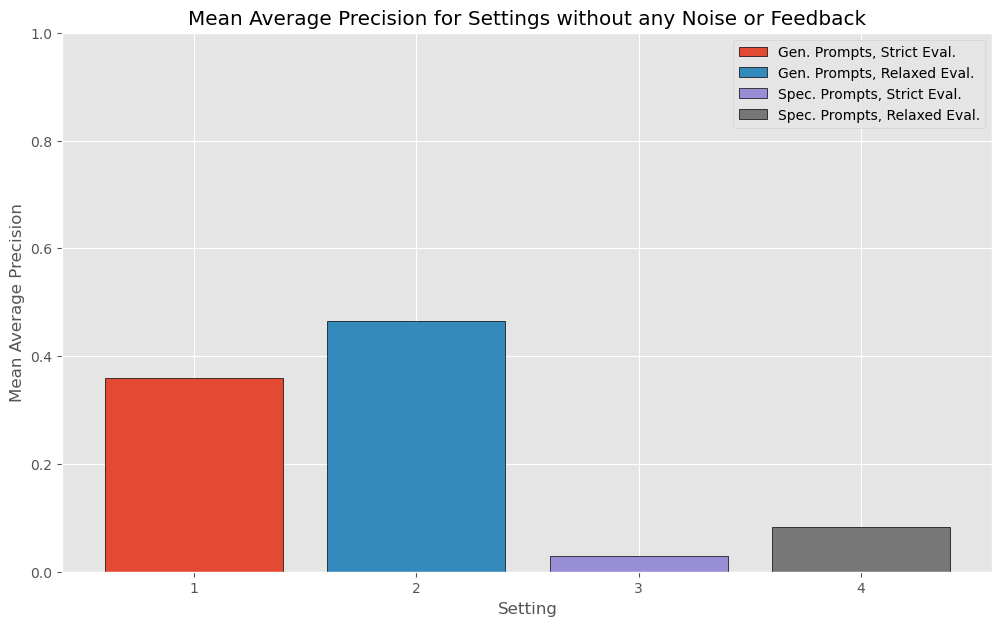

In [51]:
plot_metrics(list_data, dict_settings, title ='without any Noise or Feedback', filename='Figures/Evaluation/no_noise_no_feedback')

In [52]:
with open('Results/gen_prompts_relaxed_chain_rand_0.361_t_1_k1_25_k2_5.json', 'r') as handle:
    res1 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0.228_t_1_k1_25_k2_5.json', 'r') as handle:
    res2 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0.140_t_1_k1_25_k2_5.json', 'r') as handle:
    res3 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0.090_t_1_k1_25_k2_5.json', 'r') as handle:
    res4 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0.054_t_1_k1_25_k2_5.json', 'r') as handle:
    res5 = json.load(handle)

dict_settings = {1:'Rand: 0.361', 2:'Rand: 0.228', 3:'Rand: 0.140', 4:'Rand: 0.090', 5:'Rand: 0.054'}

list_data = [res1, res2, res3, res4, res5]

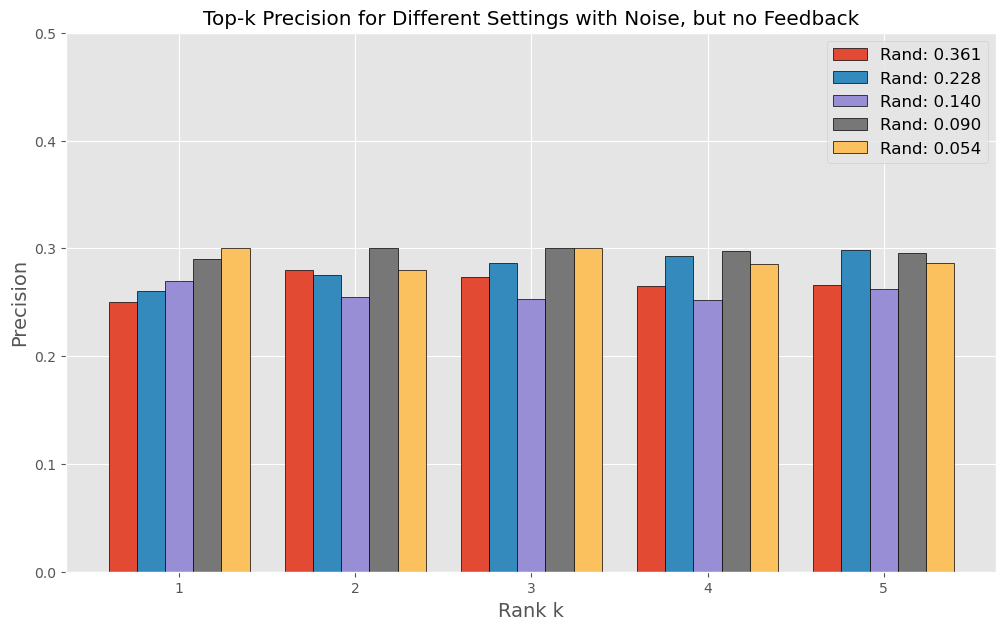

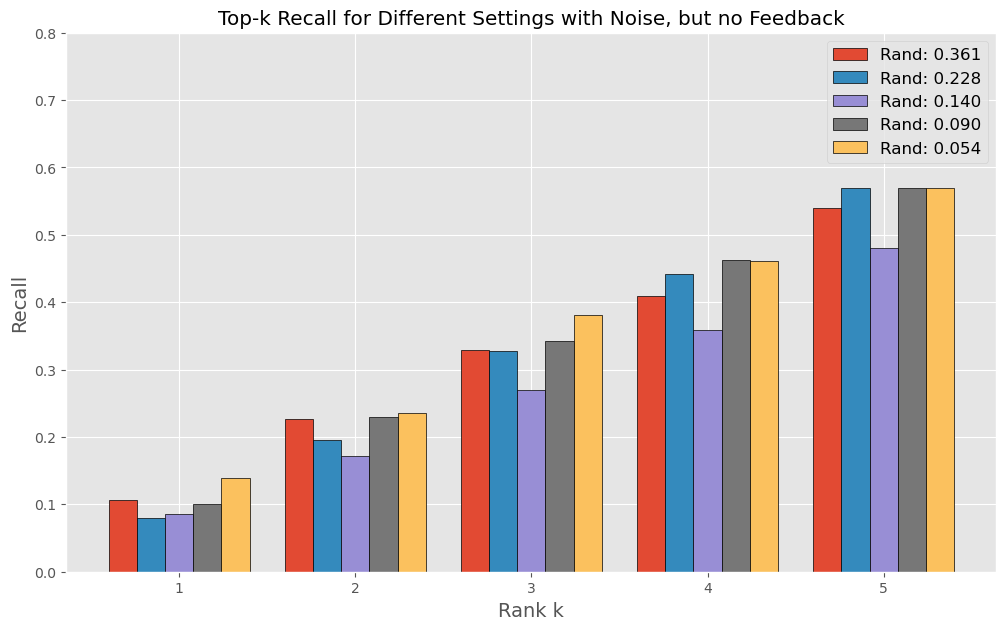

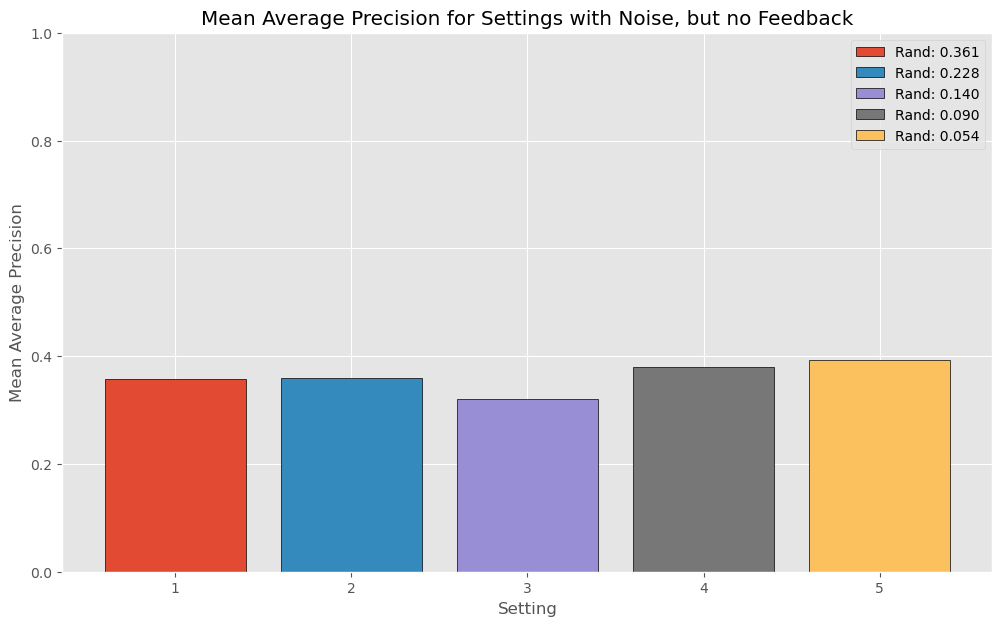

In [53]:
plot_metrics(list_data, dict_settings, title ='with Noise, but no Feedback', filename='Figures/Evaluation/noise_no_feedback')

In [54]:
with open('Results/gen_prompts_relaxed_chain_rand_0_t_0.667_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res1 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.000_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res2 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.429_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res3 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.765_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res4 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.961_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res5 = json.load(handle)

dict_settings = {1:'Temp.: 0.667', 2:'Temp.: 1.000', 3:'Temp.: 1.429', 4:'Temp.: 1.765', 5:'Temp.: 1.961'}

list_data = [res1, res2, res3, res4, res5]

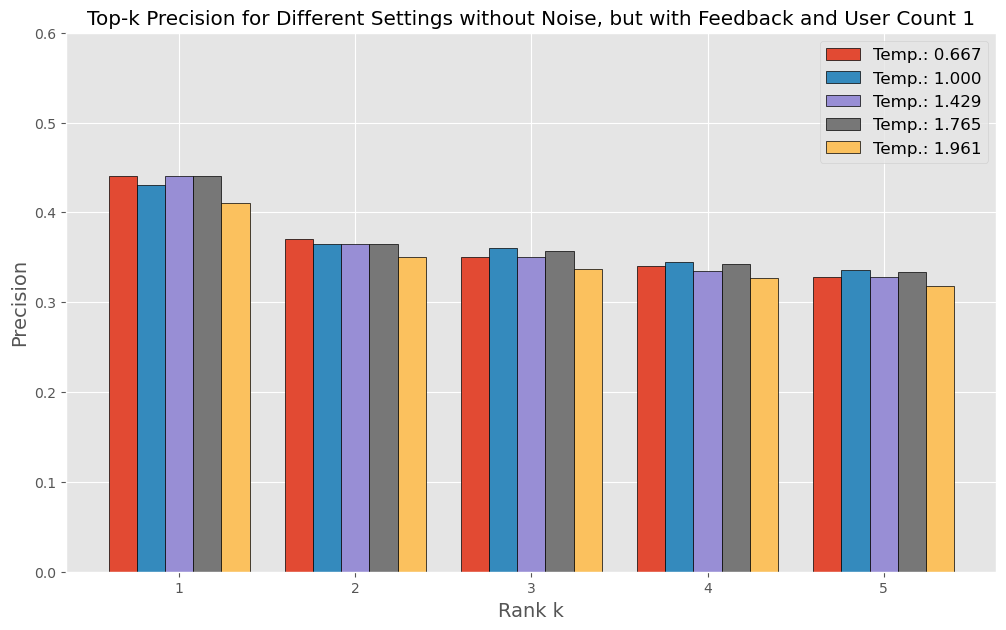

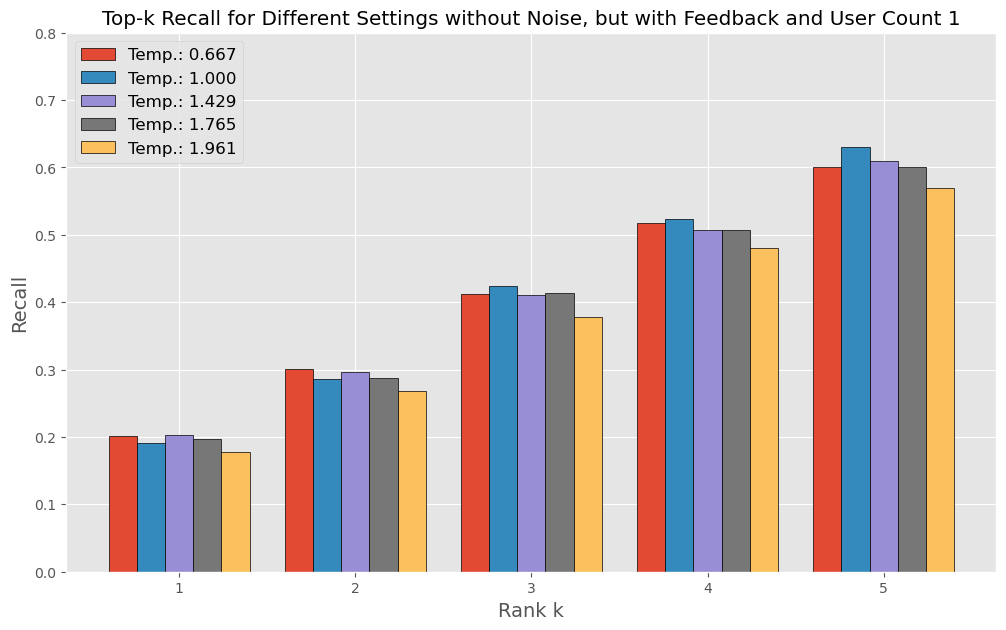

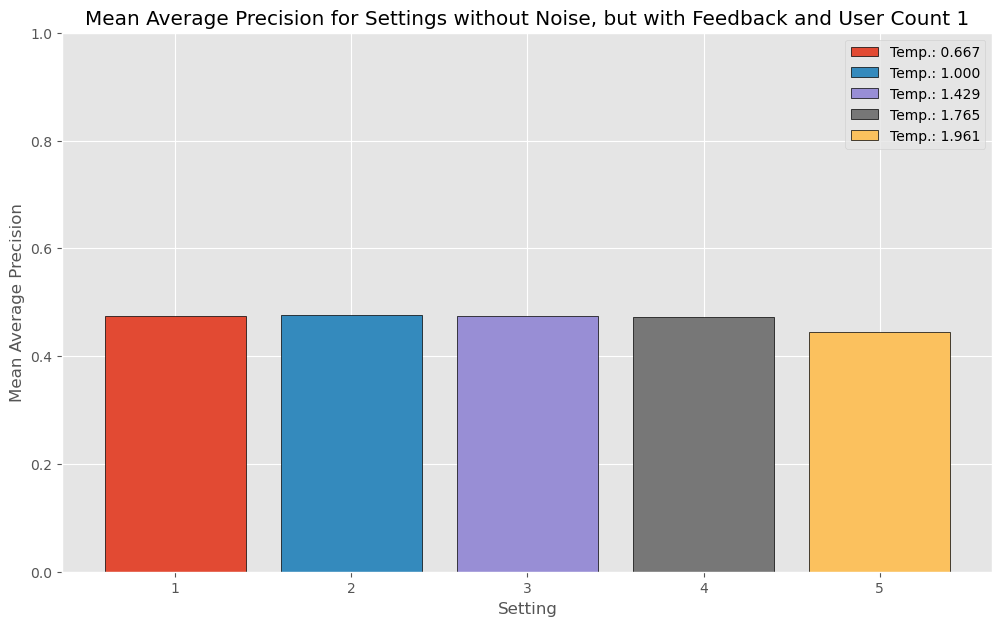

In [55]:
plot_metrics(list_data, dict_settings, title ='without Noise, but with Feedback and User Count 1', filename='Figures/Evaluation/no_noise_feedback_ucount_1')

In [56]:
with open('Results/gen_prompts_relaxed_chain_rand_0_t_0.667_k1_25_k2_5_ucount_25.json', 'r') as handle:
    res1 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.000_k1_25_k2_5_ucount_25.json', 'r') as handle:
    res2 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.429_k1_25_k2_5_ucount_25.json', 'r') as handle:
    res3 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.765_k1_25_k2_5_ucount_25.json', 'r') as handle:
    res4 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.961_k1_25_k2_5_ucount_25.json', 'r') as handle:
    res5 = json.load(handle)


dict_settings = {1:'Temp.: 0.667', 2:'Temp.: 1.000', 3:'Temp.: 1.429', 4:'Temp.: 1.765', 5:'Temp.: 1.961'}

list_data = [res1, res2, res3, res4, res5]

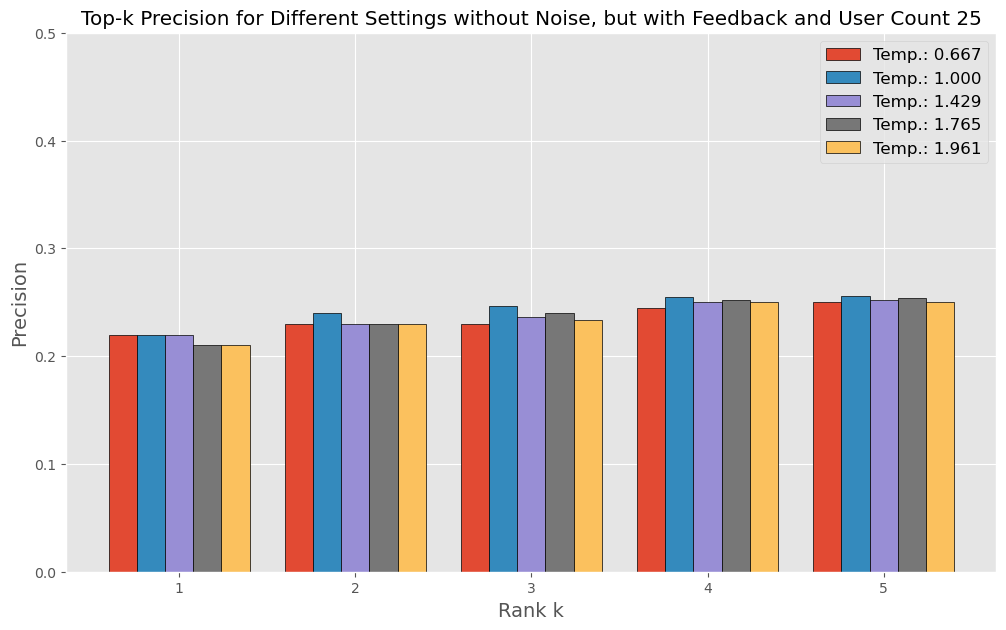

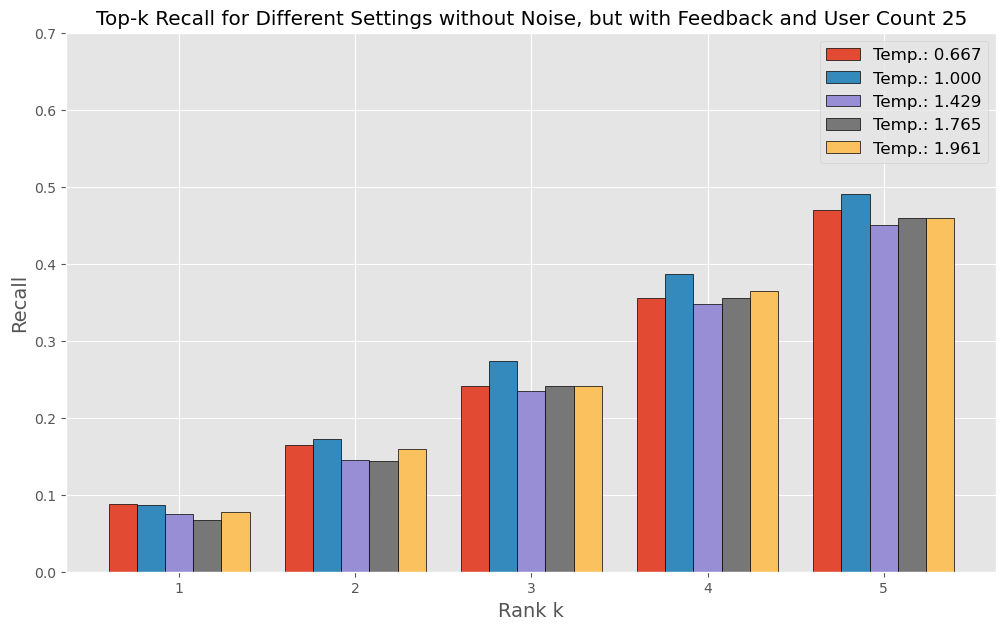

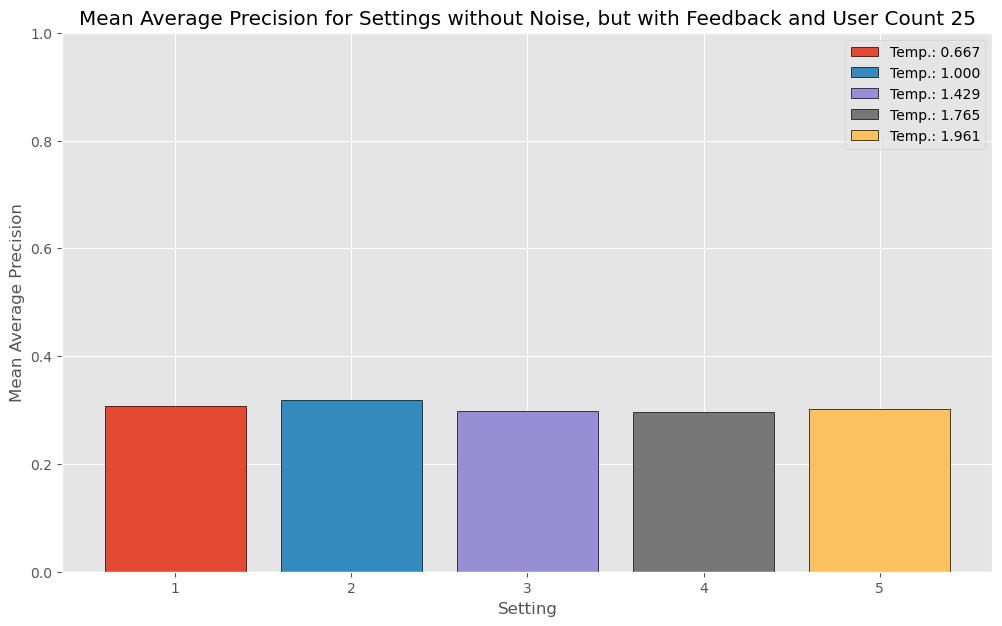

In [57]:
plot_metrics(list_data, dict_settings, title ='without Noise, but with Feedback and User Count 25', filename='Figures/Evaluation/no_noise_feedback_ucount_25')

In [64]:
with open('Results/gen_prompts_relaxed_chain_rand_0_t_0.667_k1_25_k2_5_ucount_1_top50.json', 'r') as handle:
    res1 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.000_k1_25_k2_5_ucount_1_top50.json', 'r') as handle:
    res2 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.429_k1_25_k2_5_ucount_1_top50.json', 'r') as handle:
    res3 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.765_k1_25_k2_5_ucount_1_top50.json', 'r') as handle:
    res4 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.961_k1_25_k2_5_ucount_1_top50.json', 'r') as handle:
    res5 = json.load(handle)

dict_settings = {1:'Temp.: 0.667', 2:'Temp.: 1.000', 3:'Temp.: 1.429', 4:'Temp.: 1.765', 5:'Temp.: 1.961'}

list_data = [res1, res2, res3, res4, res5]

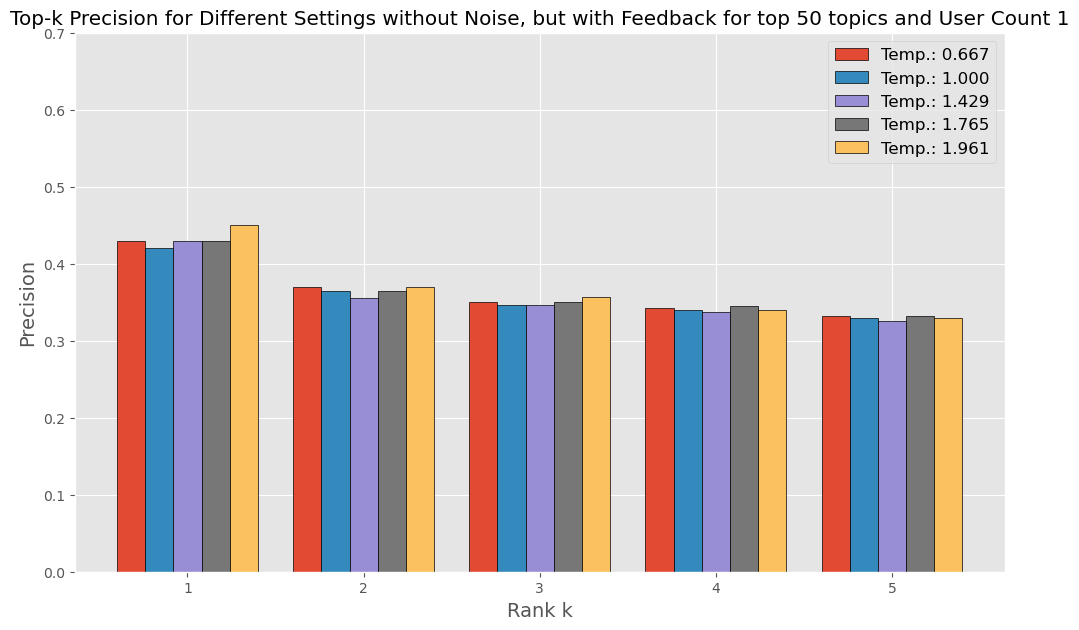

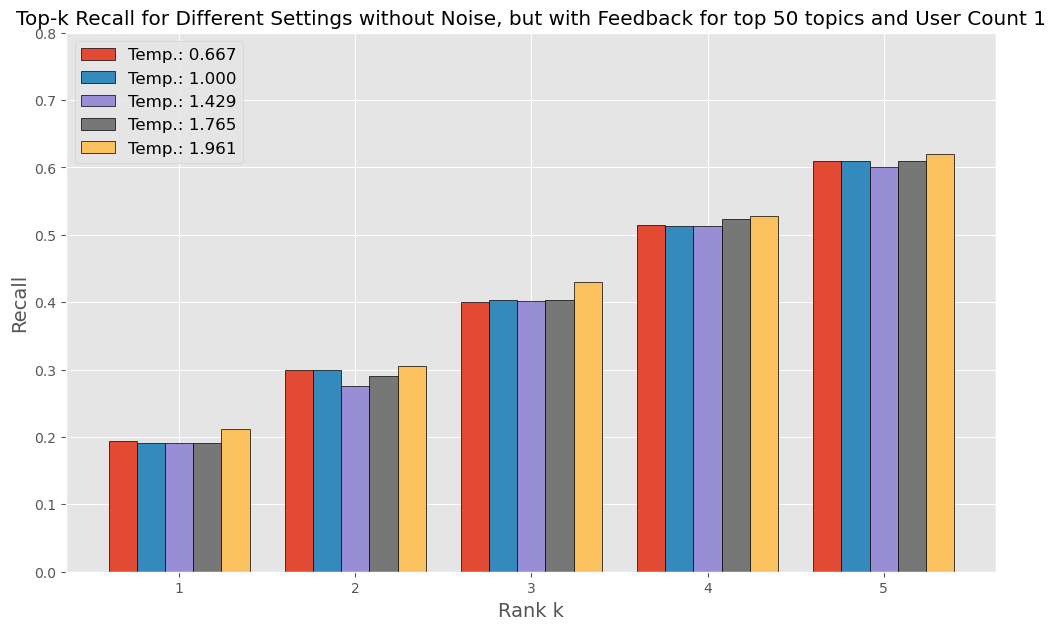

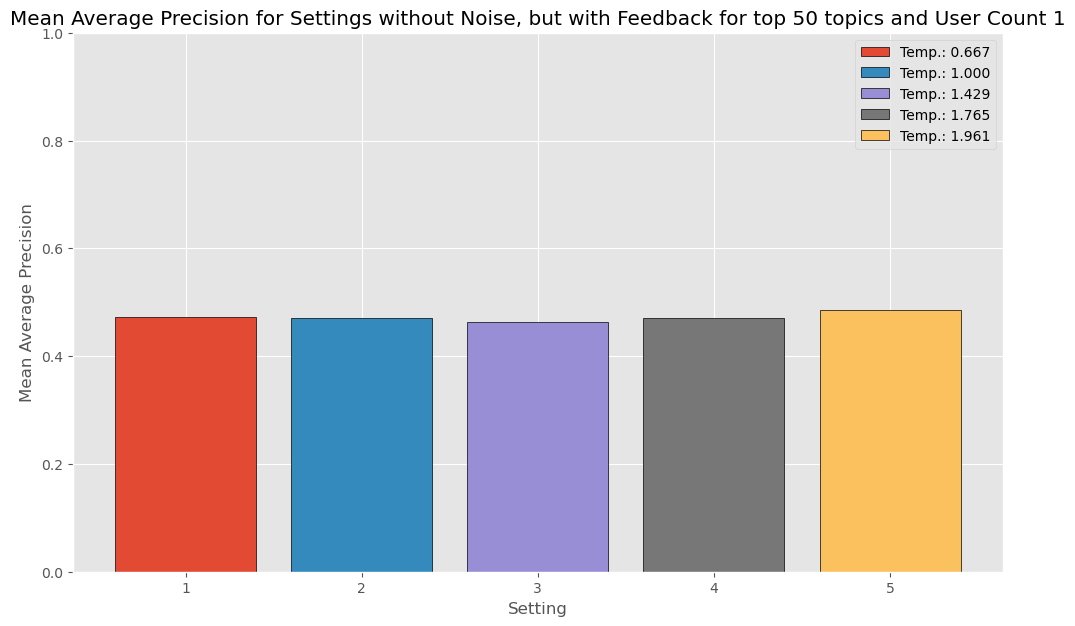

In [65]:
plot_metrics(list_data, dict_settings, title ='without Noise, but with Feedback for top 50 topics and User Count 1', filename='Figures/Evaluation/no_noise_feedback_ucount_1_top50')

In [69]:
with open('Results/gen_prompts_relaxed_chain_rand_0.361_t_0.667_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res1 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0.361_t_1.961_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res2 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0.054_t_0.667_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res3 = json.load(handle)

with open('Results/gen_prompts_relaxed_chain_rand_0.054_t_1.961_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res4 = json.load(handle)



dict_settings = {1:'Rand.: 0.361, Temp.: 0.667', 2:'Rand.: 0.361, Temp.: 1.961', 3:'Rand.: 0.054, Temp.: 0.667', 4:'Rand.: 0.054, Temp.: 1.961'}

list_data = [res1, res2, res3, res4]

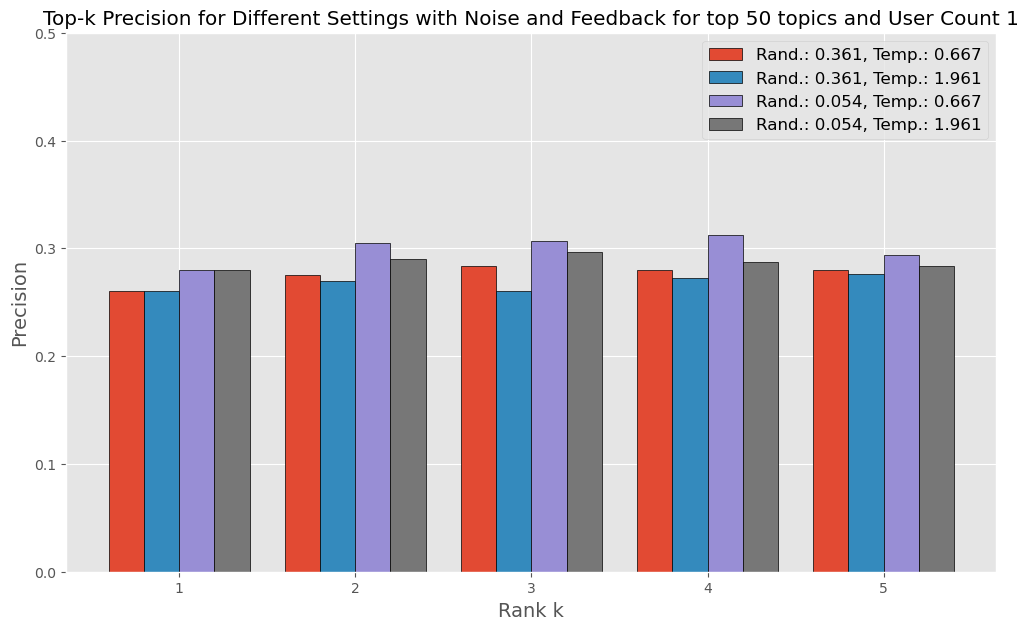

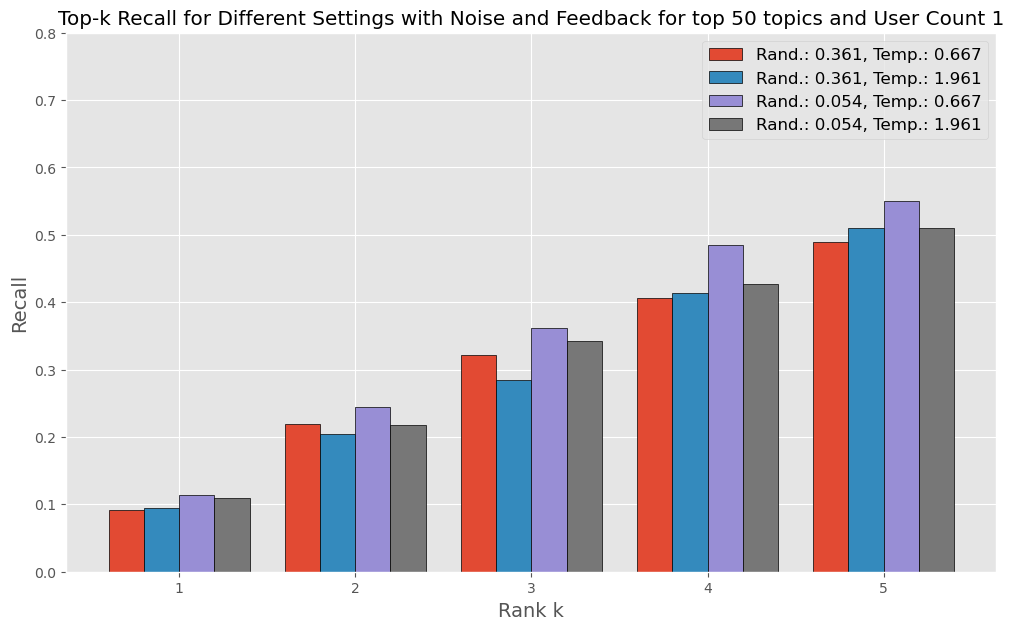

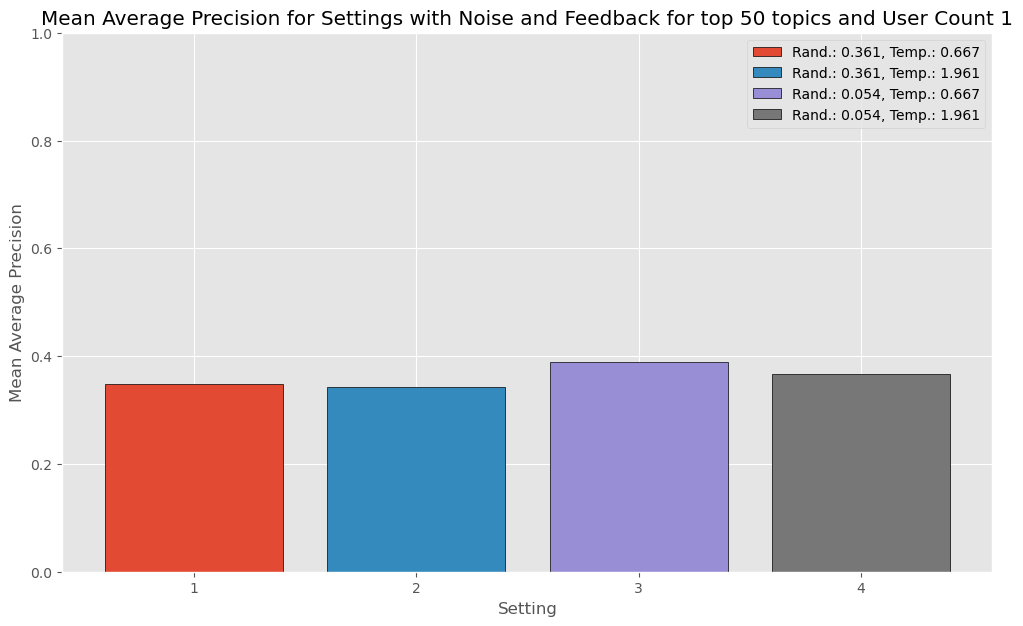

In [70]:
plot_metrics(list_data, dict_settings, title ='with Noise and Feedback for top 50 topics and User Count 1', filename='Figures/Evaluation/noise_feedback_ucount_1_top50')

In [71]:
#Baseline
with open('Results/gen_prompts_relaxed_chain_rand_0_t_1_k_5.json', 'r') as handle:
    res1 = json.load(handle)
    
#Best Noise
with open('Results/gen_prompts_relaxed_chain_rand_0.054_t_1_k1_25_k2_5.json', 'r') as handle:
    res2 = json.load(handle)
    
#Best User Feedback ucount 1
with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.000_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res3 = json.load(handle)

#Best User Feedback ucount 25
with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.000_k1_25_k2_5_ucount_25.json', 'r') as handle:
    res4 = json.load(handle)
    
#Best User Feedback ucount 50
with open('Results/gen_prompts_relaxed_chain_rand_0_t_1.961_k1_25_k2_5_ucount_1_top50.json', 'r') as handle:
    res5 = json.load(handle)
    
#Best both user feedbakck and noise
with open('Results/gen_prompts_relaxed_chain_rand_0.054_t_0.667_k1_25_k2_5_ucount_1.json', 'r') as handle:
    res6 = json.load(handle)
    

dict_settings = {1:'Baseline, No Noise, No Feedback', 2:'Noise: 0.054', 3:'Temp.: 1.000, ucount: 1', 4:'Temp.: 1.000, ucount: 25, top20 topics',5:'Temp.: 1.961, ucount: 1, top50 topics', 6:'Noise: 0.054, Temp.: 1.961, ucount: 1, top50 topics'  }

list_data = [res1, res2, res3, res4, res5, res6]


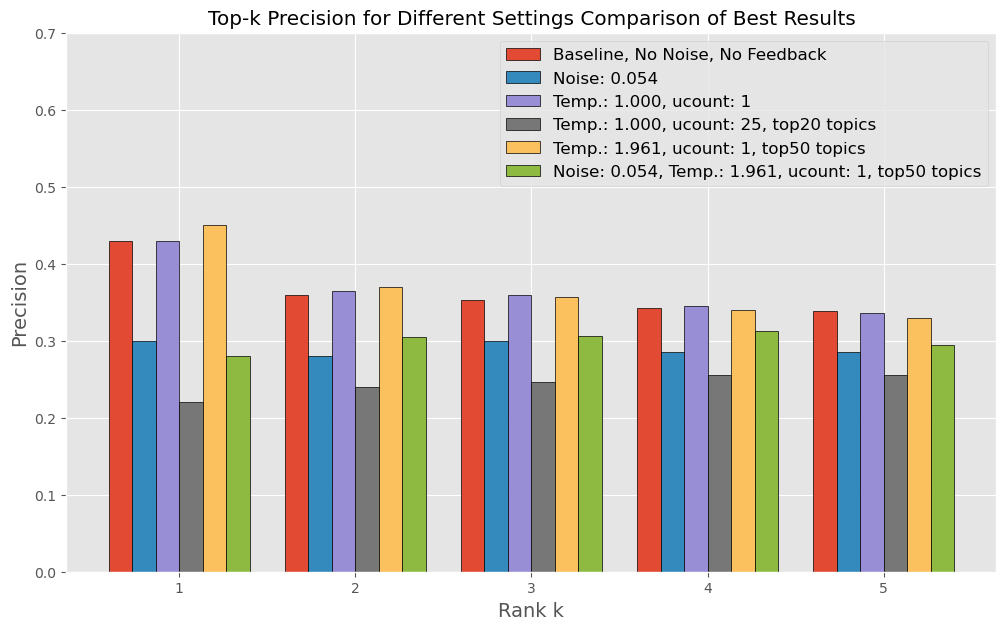

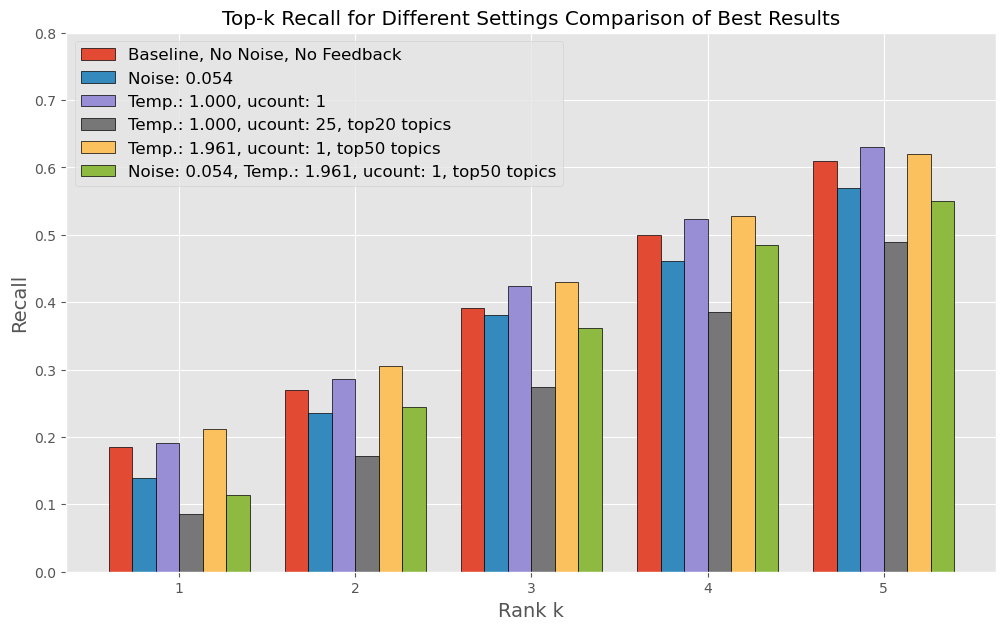

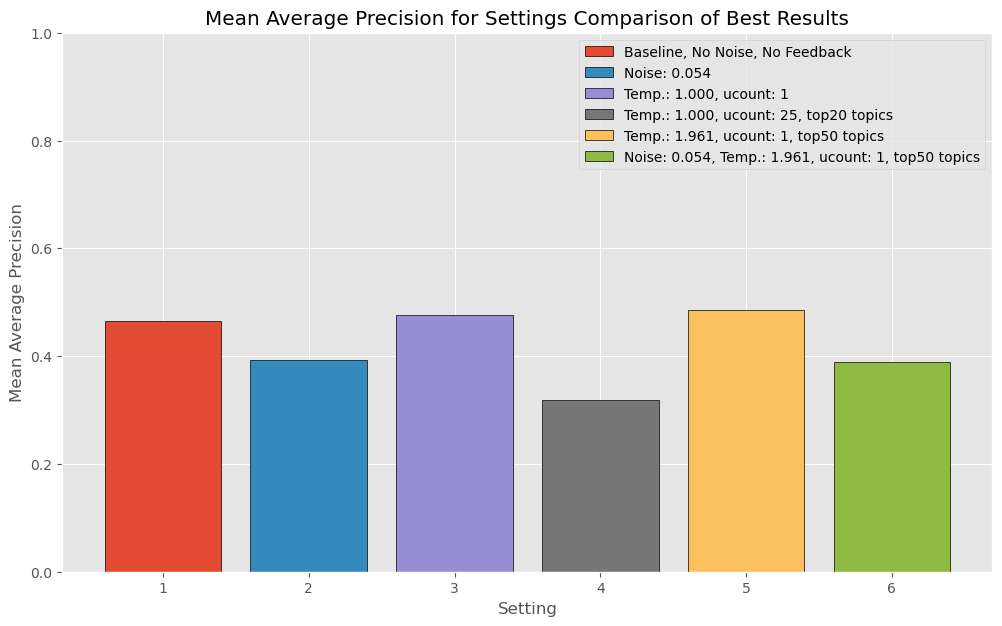

In [73]:
plot_metrics(list_data, dict_settings, title ='Comparison of Best Results', filename='Figures/Evaluation/best_results_inclusing_top50')